In [1]:
import os
os.environ["SNUDDA_DATA"] = "../../../../BasalGangliaData/data/"
assert os.path.isdir(os.getenv("SNUDDA_DATA")), f"You need to have BasalGangliaData installed for this example. You can run this example without it, but then do not execute this cell."

In [2]:
network_path = "FS_gap_junction_coupling_simulation"
experiment_config_file = "FS_gap_junction_experiment-0.json"

In [ ]:
# 80500 neurons per mm3, 1.3% are FS.
n_FS = 10
d_cube = (100/80500)**(1/3) * 1e-3

from snudda.place import create_cube_mesh
mesh_file = os.path.join(network_path, "mesh", "volume.obj")
create_cube_mesh(mesh_file, [0,0,0], d_cube, "FS network volume")

In [ ]:
from snudda.init import SnuddaInit
si = SnuddaInit(network_path=network_path, random_seed=123)

si.define_structure(struct_name="StriatalVolume", struct_mesh=mesh_file, d_min=15e-6, mesh_bin_width=50e-6)

si.add_neurons(name="FS", num_neurons=n_FS, volume_id="StriatalVolume",
               neuron_dir=os.path.join("$SNUDDA_DATA","neurons","striatum","fs"))

cluster_FS_synapses = True
cluster_FS_gap_junctions = False
FS_gGABA = [1.1e-9, 1.5e-9]
FS_gGapJunction = [0.5e-9, 0.1e-9]

if False:
    # For this example we just want gap junctions, just listing GABA here for completness
    si.add_neuron_target(neuron_name="FS",
                         target_name="FS",
                         connection_type="GABA",
                         dist_pruning=None,
                         f1=0.15, soft_max=5, mu2=2, a3=1,
                         conductance=FS_gGABA,
                         cluster_synapses=cluster_FS_synapses,
                         mod_file="tmGabaA",
                         channel_param_dictionary={"tau1": (1.33e-3, 1e3),
                                                   "tau2": (5.7e-3, 1e3)})
    
si.add_neuron_target(neuron_name="FS",
                     target_name="FS",
                     connection_type="GapJunction",
                     dist_pruning=None,
                     f1=0.7, soft_max=8, mu2=2, a3=1.0,
                     conductance=FS_gGapJunction,
                     cluster_synapses=cluster_FS_gap_junctions,
                     channel_param_dictionary=None)

si.write_json()

In [ ]:
from snudda.place import SnuddaPlace
sp = SnuddaPlace(network_path=network_path)
sp.place()

from snudda.detect import SnuddaDetect
sd = SnuddaDetect(network_path=network_path)
sd.detect()

from snudda.detect import SnuddaPrune
spr = SnuddaPrune(network_path=network_path)
spr.prune()

In [ ]:
!nrnivmodl $SNUDDA_DATA/neurons/mechanisms

In [ ]:
from snudda.simulate.pair_recording import PairRecording

pr = PairRecording(network_path=network_path, experiment_config_file=experiment_config_file)
pr.run()

In [8]:
%matplotlib notebook
from snudda.analyse.analyse_gap_junction_coupling import AnalyseGapJunctionCoupling
ac = AnalyseGapJunctionCoupling(network_path=network_path, 
                                experiment_config_file=experiment_config_file)

Loading 10 neurons with 0 synapses and 133 gap junctions
Loading FS_gap_junction_coupling_simulation/simulation/FS-gap-junction-output.hdf5


In [9]:
coupling, trace_info = ac.extract_coupling()

In [10]:
coupling, trace_info = ac.extract_coupling(duration=0.100)

<IPython.core.display.Javascript object>


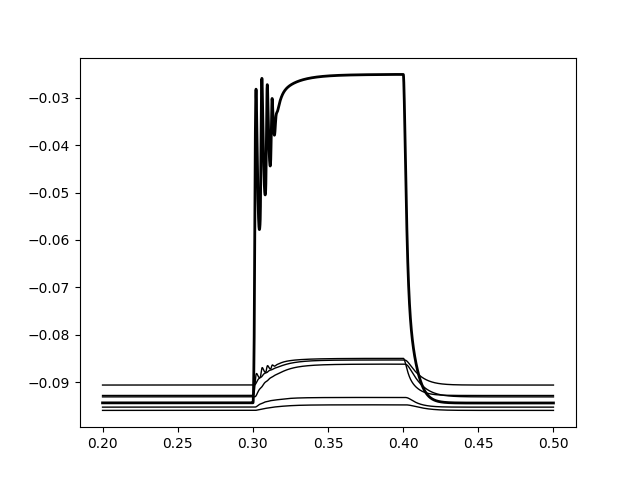

In [11]:
ac.plot_coupling(duration=0.100, amplitude=None)

In [12]:
coupling

[0.0052921283362412225,
 0.0011754985958900843,
 0.002044969219685805,
 0.0069141230751029875,
 0.00783106336920339]

In [3]:
import os
from snudda.analyse.analyse import SnuddaAnalyse
sa = SnuddaAnalyse(hdf5_file=os.path.join(network_path, "network-synapses.hdf5"))

Assuming volume type: cube [cube or full]
Only using 20000 neurons of the connection data
Loading 10 neurons with 0 synapses and 133 gap junctions
Number of neurons: 10
Created connection matrix 7.060999996610917e-05 seconds
GJ row : 0 - 0.0 %  time : 0.001233915001648711 seconds
Created gap junction connection matrix 0.001744135999615537 seconds
Creating population dictionary
Done.
!!! Setting sideLen to None
Calculating synapse distance histogram
Creating dist histogram
Created distance histogram (optimised) in 0.0010660170009941794 seconds
Saving cache to FS_gap_junction_coupling_simulation/network-synapses.hdf5-cache


Plotting connection probability FS to FS (gapjunctions)
Centering in None : Keeping 10/10
Counting connections
Requested: 10000000.0 calculated [90.]
P(d<0.00025) = 0.2777777777777778

/home/hjorth/HBP/Snudda/snudda/analyse/analyse.py:1367: RuntimeWarning: invalid value encountered in true_divide
  p_con = np.divide(count_con, count_all)



P(d<0.00025) = 0.2777777777777778


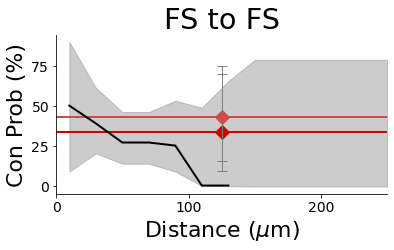

Wrote FS_gap_junction_coupling_simulation/figures/Network-distance-dependent-connection-probability-FS-to-FS-gapjunctions-3D-dist.pdf


In [5]:
# Koos & Tepper 1999, 2/6
sa.plot_connection_probability("FS", "FS",
                               dist_3d=True,
                               connection_type="gapjunctions",
                               exp_max_dist=[250e-6, 250e-6],
                               exp_data=[2 / 6.0, 3 / 7.0],
                               exp_data_detailed=[(2, 6), (3, 7)], )

Plotting number of connections
Only analysing centre post synaptic neurons, sideLen = 0.00025
Centering in None : Keeping 10/10
Calculating max synapses
Calculating mean synapses
Plotting 25 connections


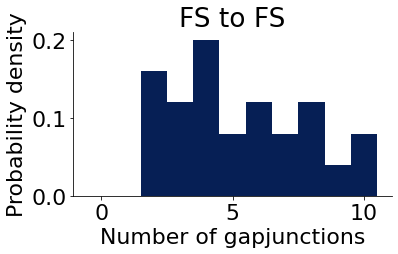

Wrote FS_gap_junction_coupling_simulation/figures/Network-number-of-gapjunctions-from-FS-to-FS-per-cell.pdf


In [6]:
sa.plot_num_synapses_per_pair("FS", "FS", connection_type="gapjunctions")

Calculating number of incoming connections FS -> FS
Centering in None : Keeping 10/10
#pre = 10, #post = 10


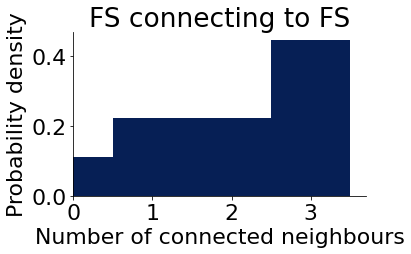

Wrote FS_gap_junction_coupling_simulation/figures/Network-gapjunctions-input-to-FS-from-FS.pdf


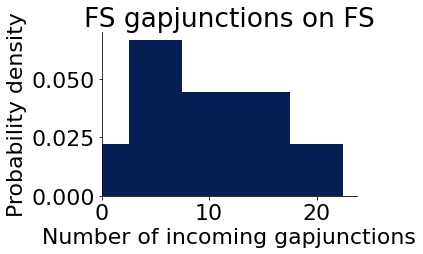

Wrote FS_gap_junction_coupling_simulation/figures/Network-gapjunctions-to-FS-from-FS.pdf


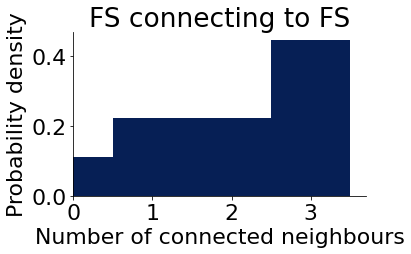

In [7]:
sa.plot_incoming_connections(neuron_type="FS", pre_type="FS", connection_type="gapjunctions")